In [1]:
import random
import numpy as np
import nltk
import matplotlib.pyplot as plt
from string import punctuation
from nltk.corpus import treebank
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras.utils import np_utils, plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier


2023-03-06 15:31:41.138220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
CUSTOM_SEED = 42
np.random.seed(CUSTOM_SEED)

nltk.download('treebank')
sentences = treebank.tagged_sents(tagset='universal')

[nltk_data] Downloading package treebank to
[nltk_data]     /home/beaudoco/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


In [3]:
tags = set([
    tag for sentence in treebank.tagged_sents() 
    for _, tag in sentence
])
print('nb_tags: %sntags: %s' % (len(tags), tags))

nb_tags: 46ntags: {'$', '-LRB-', 'NN', 'NNPS', '-RRB-', 'VBP', "''", 'RB', 'EX', 'VBZ', 'RBR', 'SYM', 'CD', 'JJR', 'DT', 'UH', '.', 'VB', 'WP$', 'TO', ':', 'WP', 'PRP', 'PDT', 'LS', 'RBS', 'NNP', '``', '-NONE-', ',', 'JJ', 'NNS', 'WDT', 'MD', 'WRB', '#', 'RP', 'VBG', 'FW', 'VBD', 'PRP$', 'POS', 'IN', 'CC', 'JJS', 'VBN'}


In [4]:
cutoff = int(.20 * len(sentences)) 
sentences = sentences[:cutoff]
train_test_cutoff = int(.80 * len(sentences)) 
training_sentences = sentences[:train_test_cutoff]
testing_sentences = sentences[train_test_cutoff:]
train_val_cutoff = int(.25 * len(training_sentences))
validation_sentences = training_sentences[:train_val_cutoff]
training_sentences = training_sentences[train_val_cutoff:]

In [5]:
def add_basic_features(sentence_terms, index):
    """ Compute some very basic word features.
        :param sentence_terms: [w1, w2, ...] 
        :type sentence_terms: list
        :param index: the index of the word 
        :type index: int
        :return: dict containing features
        :rtype: dict
    """
    term = sentence_terms[index]
    return {
        'nb_terms': len(sentence_terms),
        'term': term,
        # 'term_len': len(term),
        'is_first': index == 0,
        'is_last': index == len(sentence_terms) - 1,
        'is_capitalized': term[0].upper() == term[0],
        'is_all_caps': term.upper() == term,
        'is_all_lower': term.lower() == term,
        'contains_punc': any(p in term for p in punctuation),
        # 'punc_count': sum(p in term for p in punctuation),
        'first_char': term[0],
        # 'prefix-2': term[:2],
        # 'prefix-3': term[:3],
        # 'suffix-1': term[-1],
        # 'suffix-2': term[-2:],
        'suffix-3': term[-3:],
        'prev_word': '' if index == 0 else sentence_terms[index - 1],
        'next_word': '' if index == len(sentence_terms) - 1 else sentence_terms[index + 1]
    }

In [6]:
def untag(tagged_sentence):
    """ 
    Remove the tag for each tagged term.
:param tagged_sentence: a POS tagged sentence
    :type tagged_sentence: list
    :return: a list of tags
    :rtype: list of strings
    """
    return [w for w, _ in tagged_sentence]
def transform_to_dataset(tagged_sentences):
    """
    Split tagged sentences to X and y datasets and append some basic features.
:param tagged_sentences: a list of POS tagged sentences
    :param tagged_sentences: list of list of tuples (term_i, tag_i)
    :return: 
    """
    X, y = [], []
    for pos_tags in tagged_sentences:
            for index, (term, class_) in enumerate(pos_tags):
                # Add basic NLP features for each sentence term
                X.append(add_basic_features(untag(pos_tags), index))
                y.append(class_)
    return X, y

In [7]:
X_train, y_train = transform_to_dataset(training_sentences)
X_test, y_test = transform_to_dataset(testing_sentences)
X_val, y_val = transform_to_dataset(validation_sentences)

In [8]:
# Fit our DictVectorizer with our set of features
dict_vectorizer = DictVectorizer(sparse=False)
dict_vectorizer.fit(X_train + X_test + X_val)

print(X_train[0])
print(len(X_train))

# Convert dict features to vectors
X_train = dict_vectorizer.transform(X_train)
print(X_train.shape)
X_test = dict_vectorizer.transform(X_test)
X_val = dict_vectorizer.transform(X_val)

{'nb_terms': 22, 'term': 'Last', 'is_first': True, 'is_last': False, 'is_capitalized': True, 'is_all_caps': False, 'is_all_lower': False, 'punc_count': 0, 'first_char': 'L', 'suffix-3': 'ast', 'prev_word': '', 'next_word': 'year'}
11743
(11743, 14937)


In [9]:
# Fit LabelEncoder with our list of classes
label_encoder = LabelEncoder()
label_encoder.fit(y_train + y_test + y_val)
# Encode class values as integers
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

In [10]:
# Convert integers to dummy variables (one hot encoded)
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

In [11]:
def build_model(input_dim, hidden_neurons, output_dim):
    """
    Construct, compile and return a Keras model which will be used to fit/predict
    """
    model = Sequential([
        Dense(hidden_neurons, input_dim=input_dim),
        Activation('relu'),
        Dropout(0.2),
        Dense(hidden_neurons),
        Activation('relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
model_params = {
    'build_fn': build_model,
    'input_dim': X_train.shape[1],
    'hidden_neurons': 512,
    'output_dim': y_train.shape[1],
    'epochs': 5,
    'batch_size': 2,
    'verbose': 1,
    'validation_data': (X_val, y_val),
    'shuffle': True
}
clf = KerasClassifier(**model_params)

/tmp/ipykernel_23964/1651372650.py:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasClassifier(**model_params)


In [13]:
hist = clf.fit(X_train, y_train)

2023-03-06 15:31:48.668125: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 15:31:48.671973: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/5
5872/5872 [==============================] - 391s 66ms/step - loss: 0.6112 - accuracy: 0.8067 - val_loss: 0.2802 - val_accuracy: 0.9054
Epoch 2/5
5872/5872 [==============================] - 368s 63ms/step - loss: 0.2220 - accuracy: 0.9326 - val_loss: 0.2532 - val_accuracy: 0.9200
Epoch 3/5
5872/5872 [==============================] - 354s 60ms/step - loss: 0.1596 - accuracy: 0.9545 - val_loss: 0.2782 - val_accuracy: 0.9102
Epoch 4/5
5872/5872 [==============================] - 327s 56ms/step - loss: 0.1208 - accuracy: 0.9666 - val_loss: 0.3061 - val_accuracy: 0.9134
Epoch 5/5
5872/5872 [==============================] - 347s 59ms/step - loss: 0.0995 - accuracy: 0.9742 - val_loss: 0.2405 - val_accuracy: 0.9394


In [14]:
def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """
    blue= '#34495E'
    green = '#2ECC71'
    orange = '#E23B13'
    # plot model loss
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
    ax1.plot(range(1, len(train_loss) + 1), train_loss, blue, linewidth=5, label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, green, linewidth=5, label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    ax1.set_title('Model loss through #epochs', color=orange, fontweight='bold')
    # plot model accuracy
    ax2.plot(range(1, len(train_acc) + 1), train_acc, blue, linewidth=5, label='training')
    ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, green, linewidth=5, label='validation')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.tick_params('y')
    ax2.legend(loc='lower right', shadow=False)
    ax2.set_title('Model accuracy through #epochs', color=orange, fontweight='bold')

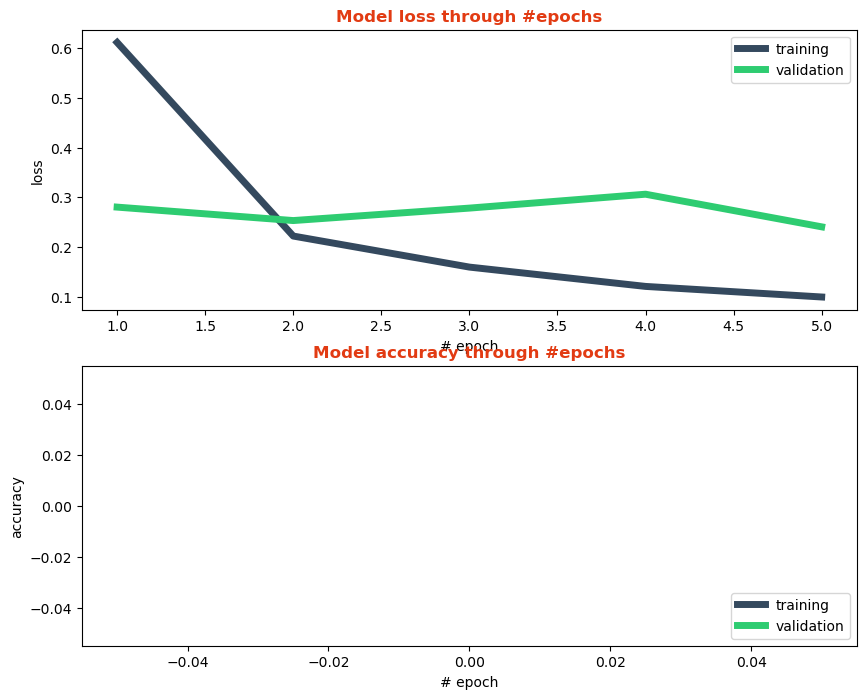

In [15]:
plot_model_performance(
    train_loss=hist.history.get('loss', []),
    train_acc=hist.history.get('acc', []),
    train_val_loss=hist.history.get('val_loss', []),
    train_val_acc=hist.history.get('val_acc', [])
)

In [16]:
score = clf.score(X_test, y_test)
print(score)

1907/1907 [==============================] - 14s 7ms/step - loss: 0.3215 - accuracy: 0.9229
0.9228953719139099


In [17]:
plot_model(clf.model, to_file='model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
clf.model.save('/tmp/keras_mlp.h5')